# Imports

In [110]:
# Imports
import os
import random
import ijson
import tqdm
import pandas as pd
import numpy as np

from collections import defaultdict
from termcolor import colored, cprint
from difflib import SequenceMatcher
import difflib


# Local code import 
from data_formatting_utils import subtokenize_code, subtokenize_comment # JIT tokenizer

# Matplotlb config
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [8., 5.]

/var/folders/mk/mqpybhtd13lb7hwmhn3221340000kt/T/ipykernel_2380/1156856878.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Configuration

In [3]:
data_path = '/Users/Ivan.Pavlov/IdeaProjects/output_new1'
unprocessed_data_path = "/Users/Ivan.Pavlov/IdeaProjects/new_dataset 2/"

# Data loading

In [4]:
dataset_files = os.listdir(data_path)

In [5]:
def read_json_file(path):
    with open(path, 'r') as json_file:
        iterator = iter(ijson.items(json_file, "item"))
        samples = []
        while True:
            try:
                sample = next(iterator)
                samples.append(sample)
            except:
                break
    return samples

# Simple Statistics

In [8]:
stats = defaultdict(list)
for pr_file in tqdm.tqdm(dataset_files):
    pr_path = os.path.join(data_path, pr_file)
    pr_samples = read_json_file(pr_path)
    
    inconsistent_samples = list(filter(lambda x: 'I' == x['label'][0], pr_samples))
    
    stats["consistent"].append(len(pr_samples) - len(inconsistent_samples))
    stats["inconsistent"].append(len(inconsistent_samples))
    #print(f"For project {pr_file} found {len(inconsistent_samples)} / {len(pr_samples)} inconsistencies")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 497/497 [00:21<00:00, 22.81it/s]


In [9]:
class_balance_df = pd.DataFrame.from_dict(stats)

In [10]:
class_balance_df.describe()

,consistent,inconsistent
count,497.000000,497.000000
mean,1363.663984,36.696177
std,3157.856303,164.945660
min,0.000000,0.000000
25%,0.000000,0.000000
50%,174.000000,1.000000
75%,1087.000000,18.000000
max,22714.000000,3218.000000


### Class Balance

In [49]:
class_balance_df.sum()

consistent      677741
inconsistent     18238
dtype: int64

In [12]:
C = 'consistent'
I = 'inconsistent'
npc = np.array(stats[C])
npi = np.array(stats[I])
# Filter uncommented projects
npi = npi[np.array(stats[I]) + np.array(stats[C]) != 0]
npc = npc[np.array(stats[I]) + np.array(stats[C]) != 0]

ratio = npi / (npc + npi)

### Documented projects ratio

In [13]:
print(f"Projects with non zero comments: {len(npi)} / {len(stats[C])}")

Projects with non zero comments: 314 / 497


In [14]:
mean_class_balance = ratio.mean()
print("Mean class balance: ", mean_class_balance)

Mean class balance:  0.028638875501726696


In [15]:
print("Mean and median for Commented projects inconsistencies count:", (npi.mean(), np.median(npi)))

Mean and median for Commented projects inconsistencies count: (58.0828025477707, 11.0)


In [16]:
print("Mean and median for Commented projects consistencies count:", (npc.mean(), np.median(npc)))

Mean and median for Commented projects consistencies count: (2158.4108280254777, 710.0)


In [17]:
print("Mean and median for Commented projects samples count:", ((npi + npc).mean(), np.median(npi + npc)))

Mean and median for Commented projects samples count: (2216.4936305732485, 746.5)


# Samples pretty print 

In [130]:
class SamplePrinter:
    def __init__(self):
        self.differ = difflib.Differ()
    
    def _show_diff(self, line_diffs):
        for diff_item in line_diffs:
            if diff_item.startswith('+'):
                cprint(diff_item, 'green')
            elif diff_item.startswith('-'):
                cprint(diff_item, 'red')
            else:
                print(diff_item)
    
    def _show_line_diffs(self, text1_lines, text2_lines): 
        self._show_diff(self.differ.compare(text1_lines, text2_lines))
        
    def print_code_diffs(self, sample):
        self._show_line_diffs(sample['oldCode'].split('\n'), sample['newCode'].split('\n'))
    
    def print_comment_diffs(self, sample):
        self._show_line_diffs(sample['oldComment'].split('\n'), sample['newComment'].split('\n'))
        
    def _show_line_delimeter(self):
        print("---" * 20)
        
    def _show_sample_frame(self):
        print('#' * 60)
        
    def pretty_print(self, sample, print_stats = False, begin_frame=True, end_frame=True):
        if begin_frame:
            self._show_sample_frame()
        self._show_line_delimeter()
        print(f"Project {sample['project']}", end=' ')
        if sample['label'].startswith('I'):
            cprint(sample['label'], 'red', attrs=['bold'], end=' ')
        else:
            cprint(sample['label'], 'green', attrs=['bold'], end=' ')
        print("sample")
        self._show_line_delimeter()
        self.print_comment_diffs(sample)
        self._show_line_delimeter()
        self.print_code_diffs(sample)
        if print_stats:
            ...
        if end_frame:
            self._show_sample_frame()
    
    def print_list(self, samples):
        for i, s in enumerate(samples):
            if i == len(samples) - 1:
                self.pretty_print(s)
            else:
                self.pretty_print(s, end_frame=False)

# Map on all samples 

In [19]:
def map_samples(func, context = None, files=dataset_files):
    for pr_file in tqdm.tqdm(files):
        pr_path = os.path.join(data_path, pr_file)
        pr_samples = read_json_file(pr_path)
        if context is not None:
            func(pr_samples, context)
        else:
            func(pr_samples)
    return context

# Samples utils

def get_consistent(samples):
    return list(filter(lambda x: not x['label'].startswith('I'), samples))

def get_inconsistent(samples):
    return list(filter(lambda x: x['label'].startswith('I'), samples))    

# Removed/Added count 

In [122]:
context = {}
context['added_code'] = defaultdict(list)
context['deleted_code'] = defaultdict(list)

context['added_doc'] = defaultdict(list)
context['deleted_doc'] = defaultdict(list)


def tokenize_code_alnum(code: str):
    return list(filter(lambda x: x.isalnum(), subtokenize_code(code).split(' ')))


def tokenize_doc_alnum(doc: str):
    return list(filter(lambda x: x.isalnum(), subtokenize_comment(doc).split(' ')))


def action_stats(samples, context):
    for s in samples:
        project = s['project']
        old_tokens, new_tokens = tokenize_code_alnum(s['oldCode']), tokenize_code_alnum(s['newCode'])
        inserted, deleted = understand_opcode(SequenceMatcher(None, old_tokens, new_tokens).get_opcodes())
        context['added_code'][project].append(inserted)
        context['deleted_code'][project].append(deleted)
    
    for s in get_inconsistent(samples):
        project = s['project']
        old_tokens, new_tokens = tokenize_doc_alnum(s['oldComment']), tokenize_doc_alnum(s['newComment'])
        inserted, deleted = understand_opcode(SequenceMatcher(None, old_tokens, new_tokens).get_opcodes())
        context['added_doc'][project].append(inserted)
        context['deleted_doc'][project].append(deleted)
    return context
    
    
    


In [123]:
add_remove_stats2 = map_samples(
    action_stats,
    context
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 497/497 [00:34<00:00, 14.29it/s]


In [125]:
mean_added_code = [np.mean(v) for p, v in add_remove_stats['added_code'].items()]
mean_deleted_code = [np.mean(v) for p, v in add_remove_stats['deleted_code'].items()]
mean_added_doc = [np.mean(v) for p, v in add_remove_stats2['added_doc'].items()]
mean_deleted_doc = [np.mean(v) for p, v in add_remove_stats2['deleted_doc'].items()]

In [129]:
import json
with open('add_remove_stats_497.json', 'w') as json_file:
    json.dump(add_remove_stats, json_file)

In [127]:
mean_changed_code = [np.mean(np.array(add_remove_stats['added_code'][p]) + np.array(add_remove_stats['deleted_code'][p])) 
                     for p in add_remove_stats['added_code'].keys()]
mean_changed_doc = [np.mean(np.array(add_remove_stats2['added_doc'][p]) + np.array(add_remove_stats2['deleted_doc'][p])) 
                     for p in add_remove_stats['added_doc'].keys()]

print('Median code change: ', np.median(mean_changed_code))
print('Median doc change: ', np.median(mean_changed_doc))

np.mean(mean_deleted_doc)

Median code change:  16.855422765370093
Median doc change:  10.0


6.466819032696893

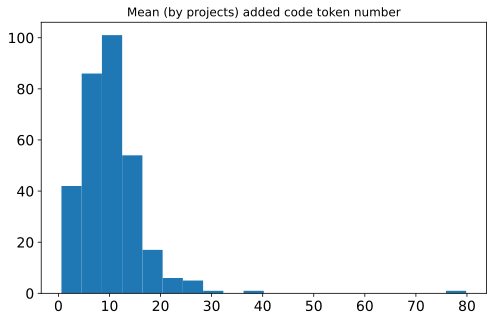

In [164]:

fig, axs = plt.subplots()
axs.hist(mean_added_code, bins=20)
axs.set_title('Mean (by projects) added code token number')
plt.show()

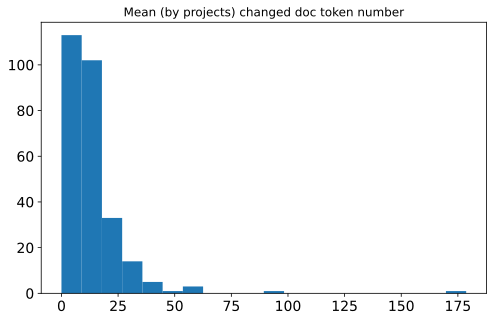

In [163]:
fig, axs = plt.subplots()
axs.hist(mean_changed_doc, bins=20)
axs.set_title('Mean (by projects) changed doc token number')
plt.show()

# Documented methods ratio 

In [152]:
# read statistics saved on ssh machine and copied to local machine to txt file
with open('/Users/Ivan.Pavlov/IdeaProjects/new_stats.jsonl', 'r') as doc_stats_file:
    stats_list = [json.loads(s) for s in doc_stats_file.read().strip().split('\n')]

In [169]:
methods_stats = [st['numOfMethods'] for st in stats_list if st['numOfMethods'] != 0]
doc_methods_stats = [st['numOfDocMethods'] for st in stats_list if st['numOfMethods'] != 0]

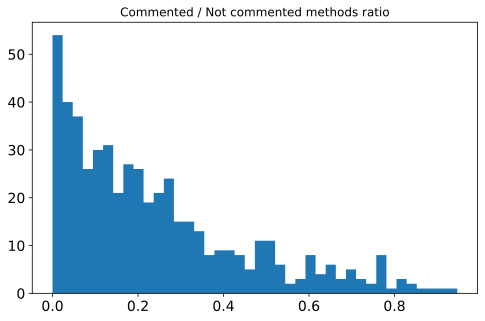

In [178]:
ratio = np.array(doc_methods_stats) / np.array(methods_stats)


fig, axs = plt.subplots()
axs.hist(ratio, bins=40, density=False, histtype='stepfilled')
axs.set_title('Commented / Not commented methods ratio')
plt.savefig('doc_ratio.png')
plt.show()

# Refactorings statistics

In [186]:

context = defaultdict(int)

def refactorings_stats(samples, context):
    for s in samples:
        for r in ['isRenamed', 'isParamAdded', 'isParamRemoved',
                  'isReturnTypeChanged', 'isParamTypeChanged', 'isParamRenamed']:
            context[r] += int(s['metric'][r])
    return context
        

refactrs = map_samples(
    refactorings_stats,
    context
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 497/497 [00:24<00:00, 20.53it/s]


Text(0.5, 1.0, 'Refactorings distribution')

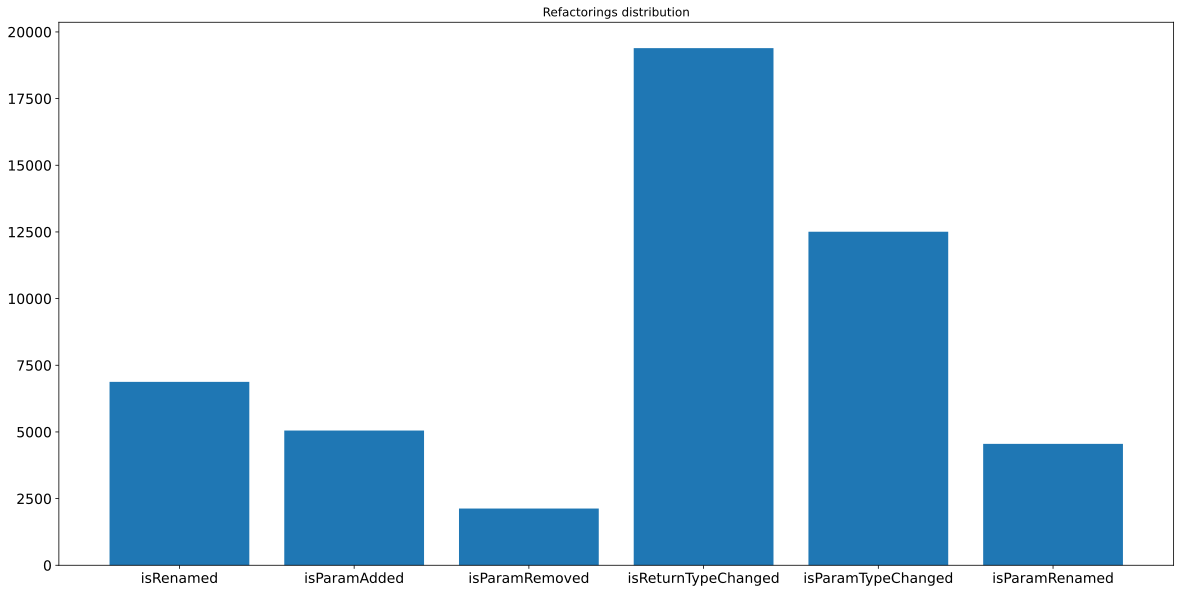

In [199]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.bar(refactrs.keys(), refactrs.values())
axs.set_title('Refactorings distribution')

# Jumps Length

In [201]:
with open('/Users/Ivan.Pavlov/IdeaProjects/hashes.txt', 'r') as hashes_file:
    hashes_dict = json.load(hashes_file)
    # load dict (project_name -> git log --all list of commit hashes)

In [209]:

context = defaultdict(list)

def jumps_stats(samples, context):
    for s in get_inconsistent(samples):
        old, new = s['oldCommit'], s['newCommit']
        pr = s['project']
        if pr in hashes_dict:
            commit_list = hashes_dict[pr]
            if old in commit_list and new in commit_list:
                context[pr].append(abs(commit_list.index(new) - commit_list.index(old)))
    return context

jumps = map_samples(
    jumps_stats,
    context
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 497/497 [00:33<00:00, 14.94it/s]


In [214]:
print(jumps)

defaultdict(<class 'list'>, {'apache#sqoop': [17, 123, 123], 'apache#incubator-hivemall': [6, 6, 6, 35], 'apache#gora': [6, 6, 30, 30, 30, 30, 30, 2, 11, 330, 78, 4, 17, 20, 23, 1, 48, 22, 48, 910, 910, 514, 514, 171, 1, 7, 118, 491], 'aaberg#sql2o': [12], 'alibaba#canal': [29, 4, 20, 15, 161, 3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 88, 88, 88, 88, 88, 88, 88, 98, 98, 98, 88, 88, 88, 88, 88, 98, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 98, 88, 88, 98, 88, 98, 88, 88, 88, 98, 88, 88, 98, 88, 98, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 98, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 98, 88, 88, 88, 88, 88, 88, 88

In [215]:
mean_jumps = [np.mean(v) for p, v in jumps.items()]

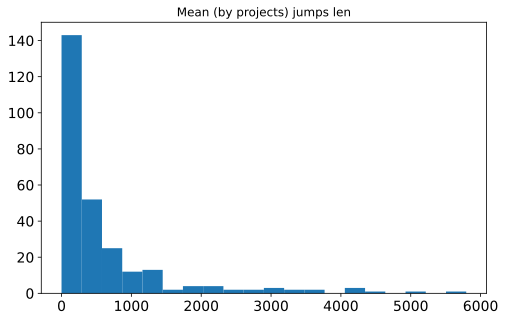

In [216]:
fig, axs = plt.subplots()
axs.hist(mean_jumps, bins=20)
axs.set_title('Mean (by projects) jumps len')
plt.show()